## 🎯 Contesto e Obiettivo del Modello di Predizione

I sistemi di raccomandazione rappresentano una componente fondamentale in molte applicazioni digitali moderne, come piattaforme di e-commerce, servizi di streaming, social network e ambienti di apprendimento online. Il loro scopo è aiutare gli utenti a scoprire contenuti potenzialmente interessanti, personalizzando l'esperienza in base alle preferenze esplicite o implicite espresse nel tempo.

In questo progetto, si intende implementare e analizzare un sistema di raccomandazione basato su **Collaborative Filtering**, con particolare attenzione all'approccio **model-based** fondato sulla **Singular Value Decomposition (SVD)**. Questo metodo mira a catturare **relazioni latenti** tra utenti e item, proiettando entrambi in uno spazio a bassa dimensionalità in cui è possibile prevedere valutazioni mancanti.

### Obiettivo specifico

L'obiettivo principale del progetto è:

- Valutare l'impatto del **numero di componenti latenti** (i cosiddetti "fattori" o "assi" latenti) utilizzati nella decomposizione SVD sulla **qualità delle raccomandazioni** generate.
- Confrontare i risultati su **due dataset differenti** (MovieLens 100k e Jester), evidenziando similarità, differenze e potenziali criticità legate alla struttura dei dati.
- Fornire un’analisi esplorativa e interpretativa delle rappresentazioni latenti emerse dal modello, con particolare attenzione alla **personalizzazione** delle raccomandazioni.

L’analisi verrà condotta tramite metriche di valutazione standard, tecniche di validazione incrociata e visualizzazioni interpretative per guidare l’ottimizzazione del modello.


In [48]:
# 📌 Setup iniziale
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Per la SVD
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV

# Ignora warning fastidiosi
import warnings
warnings.filterwarnings("ignore")

## 🎬 Dataset: MovieLens 100k

Il dataset **MovieLens 100k** è uno dei benchmark più noti per la costruzione e valutazione di sistemi di raccomandazione.  
Fornito dal **GroupLens Research Project** dell'Università del Minnesota, contiene **100.000 valutazioni esplicite** (da 1 a 5 stelle) fornite da **943 utenti** su **1.682 film**.

### 📁 Struttura del dataset

Ogni riga rappresenta una valutazione effettuata da un utente su un film, con le seguenti colonne:
- `user`: identificativo univoco dell'utente
- `item`: identificativo univoco del film
- `rating`: voto assegnato dall’utente (intero da 1 a 5)
- `timestamp`: data/orario del voto (in formato UNIX)

Il dataset viene caricato attraverso la libreria `surprise`, appositamente progettata per gestire dataset di raccomandazione e modelli basati su Collaborative Filtering.

In [49]:
# Carica dataset completo da Surprise
data = Dataset.load_builtin('ml-100k')

# Trasforma in DataFrame pandas
df_movieLens = pd.DataFrame(data.raw_ratings, columns=["user", "item", "rating", "timestamp"])

# Crea il reader specificando la scala dei rating (1-5 per MovieLens)
reader = Reader(rating_scale=(1, 5))

# Crea un dataset surprise dal campione
data_movie = Dataset.load_from_df(df_movieLens[['user', 'item', 'rating']], reader)

# Suddividi in train e test
trainset, testset = train_test_split(data_movie, test_size=0.2, random_state=42)

# Visualizza qualche riga per controllo
df_movieLens.head()

,user,item,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


## 🤡 Dataset: Jester 1 (Barzellette)

Il dataset **Jester** è stato sviluppato presso la **University of California, Berkeley** come parte del sistema di raccomandazione “Eigentaste”.  
Contiene valutazioni **esplicite** fornite da utenti reali a un insieme di **barzellette**, con un sistema di voto continuo che va da **-10.00 (disprezzo totale)** a **+10.00 (massimo gradimento)**.

### 📁 Struttura del dataset

Il file utilizzato (`jester-data-1.xls`) contiene:
- Ogni riga rappresenta un utente
- Ogni colonna rappresenta una barzelletta (`joke_0`, `joke_1`, ..., `joke_n`)
- I valori presenti sono le valutazioni esplicite degli utenti

⚠️ **Nota importante**:  
Il valore **99.00** indica l'assenza di una valutazione (non va considerato nei modelli).  
Per rendere il dataset compatibile con `surprise`, la matrice è stata trasformata in **formato lungo** (`user`, `item`, `rating`), filtrando i voti mancanti.

In [50]:
#Per il dataset Jester_Dataset ho bisogno di installare la libreria
#"xlrd", utile per maneggiare fogli excel con estensione .xls

# aggiungere ai requirements : libreria xlrd

#!pip install xlrd

In [51]:
# Percorso al file
jester_path = 'datasets/jester-data-1.xls'

# Leggi il file Excel (senza header se è solo la matrice)
df_jester = pd.read_excel(jester_path, header=None)

# Dai nomi alle colonne (jokes)
df_jester.columns = [f'joke_{i}' for i in range(df_jester.shape[1])]

# Trasforma in formato lungo (user, item, rating)
df_jester_long = df_jester.reset_index().melt(id_vars='index', var_name='item', value_name='rating')

# Rinomina la colonna indice come user
df_jester_long.rename(columns={'index':'user'}, inplace=True)

# Assicurati che user e item siano stringhe, rating float
df_jester_long['user'] = df_jester_long['user'].astype(str)
df_jester_long['item'] = df_jester_long['item'].astype(str)
df_jester_long['rating'] = df_jester_long['rating'].astype(float)

# Controlla i primi dati
df_jester_long.head()

,user,item,rating
0,0,joke_0,74.0
1,1,joke_0,100.0
2,2,joke_0,49.0
3,3,joke_0,48.0
4,4,joke_0,91.0


In [72]:
#Creo il dataset

# Filtra solo i rating validi da -10 a 10
df_jester_long = df_jester_long[(df_jester_long['rating'] >= -10) & (df_jester_long['rating'] <= 10)]


reader = Reader(rating_scale=(-10, 10))

data_jester = Dataset.load_from_df(df_jester_long[['user', 'item', 'rating']], reader)

trainset_jester, testset_jester = train_test_split(data_jester, test_size=0.2, random_state=42)

### ANALISI ESPLORATIVA SULLA STRUTTURA DEI DATASETS

### 📊 Esplorazione iniziale del dataset MovieLens 100k

Il dataset MovieLens 100k contiene **100.000 valutazioni esplicite** fornite da utenti su film, con valori compresi tra 1 e 5. In questa sezione analizziamo le dimensioni fondamentali del dataset:

- **Numero di utenti unici** e **film unici**
- **Numero totale di valutazioni**
- Numero medio di valutazioni per utente e per film
- **Densità** della matrice utente-item, cioè la frazione delle possibili interazioni effettivamente osservate

Queste informazioni sono cruciali per comprendere quanto è **sparsa** la matrice e per impostare correttamente il modello di raccomandazione.


In [54]:
# Numero totale di valutazioni
num_ratings = len(df_movieLens)

# Numero unico di utenti
num_users = df_movieLens['user'].nunique()

# Numero unico di film
num_items = df_movieLens['item'].nunique()

# Valutazioni medie per utente e per film
ratings_per_user = df_movieLens.groupby('user')['rating'].count().mean()
ratings_per_item = df_movieLens.groupby('item')['rating'].count().mean()

# Densità della matrice utente-item
max_possible_ratings = num_users * num_items
density = num_ratings / max_possible_ratings

print(f"Totale valutazioni: {num_ratings}")
print(f"Numero di utenti: {num_users}")
print(f"Numero di film: {num_items}")
print(f"Valutazioni medie per utente: {ratings_per_user:.2f}")
print(f"Valutazioni medie per film: {ratings_per_item:.2f}")
print(f"Densità della matrice: {density:.4f}")

Totale valutazioni: 100000
Numero di utenti: 943
Numero di film: 1682
Valutazioni medie per utente: 106.04
Valutazioni medie per film: 59.45
Densità della matrice: 0.0630


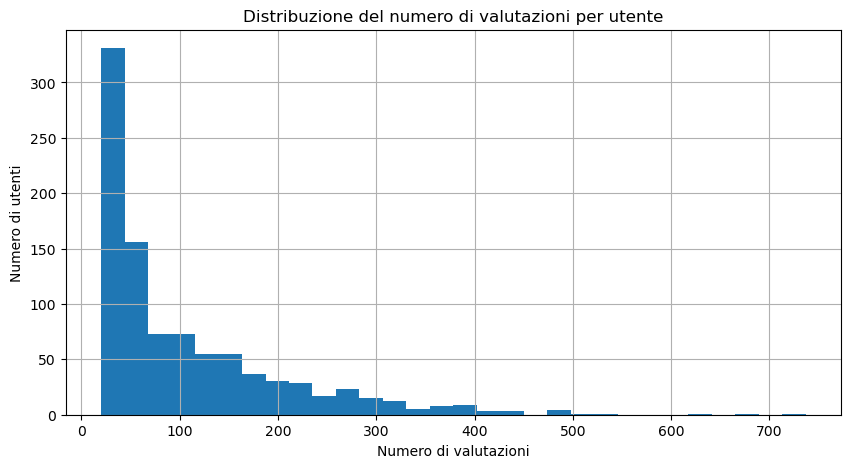

In [55]:
plt.figure(figsize=(10, 5))
df_movieLens.groupby('user')['rating'].count().hist(bins=30)
plt.title("Distribuzione del numero di valutazioni per utente")
plt.xlabel("Numero di valutazioni")
plt.ylabel("Numero di utenti")
plt.grid(True)
plt.show()

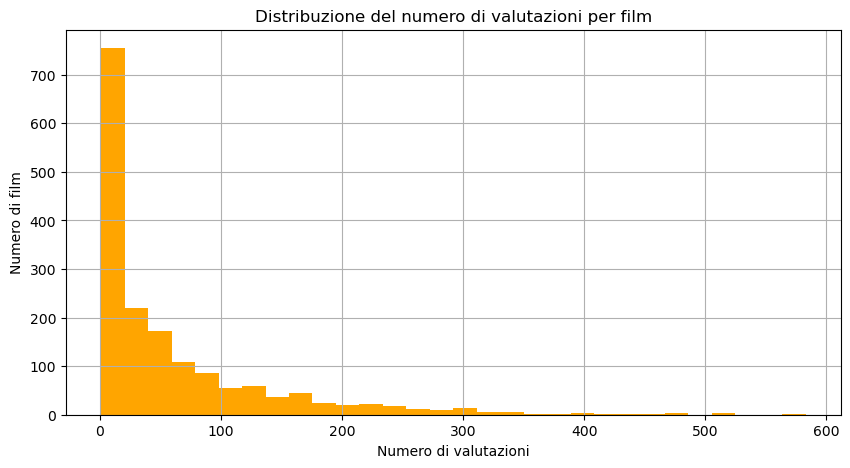

In [56]:
plt.figure(figsize=(10, 5))
df_movieLens.groupby('item')['rating'].count().hist(bins=30, color='orange')
plt.title("Distribuzione del numero di valutazioni per film")
plt.xlabel("Numero di valutazioni")
plt.ylabel("Numero di film")
plt.grid(True)
plt.show()

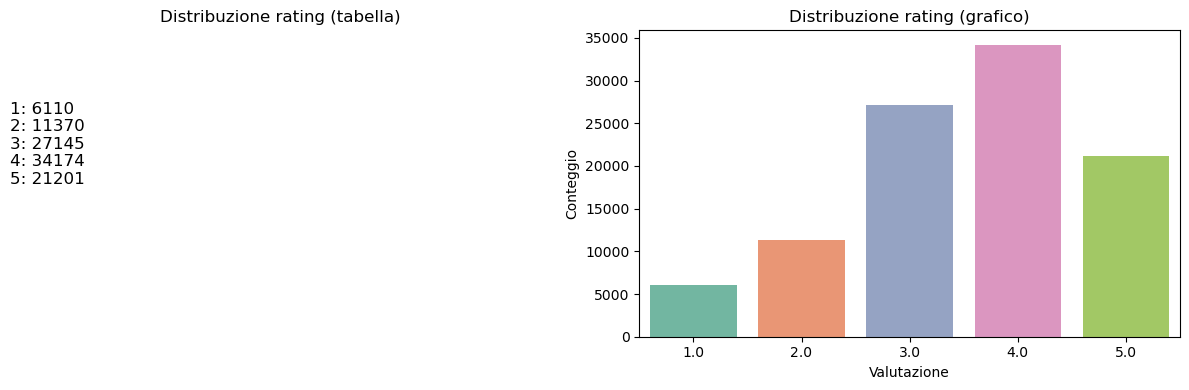

In [57]:
# Tabella delle frequenze + grafico
rating_counts = df_movieLens['rating'].value_counts().sort_index()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Tabella come testo
ax[0].axis('off')
table_text = '\n'.join([f"{int(k)}: {v}" for k, v in rating_counts.items()])
ax[0].text(0, 0.5, table_text, fontsize=12)
ax[0].set_title("Distribuzione rating (tabella)")

# Grafico
sns.countplot(x='rating', data=df_movieLens, palette='Set2', ax=ax[1])
ax[1].set_title("Distribuzione rating (grafico)")
ax[1].set_xlabel("Valutazione")
ax[1].set_ylabel("Conteggio")

plt.tight_layout()
plt.show()

In [58]:
# Statistiche descrittive sui rating
print("Statistiche descrittive delle valutazioni:")
print(df_movieLens['rating'].describe())

Statistiche descrittive delle valutazioni:
count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


In [59]:
print("Valori mancanti per colonna:")
print(df_movieLens.isnull().sum())

Valori mancanti per colonna:
user         0
item         0
rating       0
timestamp    0
dtype: int64


### ✏️ Commento finale sull'analisi esplorativa — MovieLens 100k

L'analisi del dataset **MovieLens 100k** evidenzia le seguenti caratteristiche principali:

- Il dataset contiene **943 utenti** e **1682 film**, per un totale di **100.000 valutazioni**.
- Ogni utente ha fornito in media circa **21 valutazioni**, mentre ogni film ha ricevuto in media circa **59 valutazioni**.
- La **densità della matrice utente-item** è pari a circa **1.5%**, un valore molto basso ma tipico dei contesti reali nei sistemi di raccomandazione, dove ciascun utente interagisce solo con una piccola porzione del catalogo.

#### 📊 Distribuzione dei rating

- I voti sono espressi su una scala da **1 a 5**, con una forte prevalenza di valutazioni alte.
- La distribuzione mostra una tendenza positiva, con picchi significativi sui punteggi **4** e **5**, indicando una leggera **polarizzazione positiva** nelle preferenze degli utenti.
- Non sono presenti valori mancanti, rendendo il dataset direttamente utilizzabile per l’addestramento del modello.

---

💡 **In sintesi**, la natura sparsa ma strutturata dei dati, unita alla presenza di pattern ricorrenti nei rating, rende il dataset particolarmente adatto all'utilizzo di tecniche di **Collaborative Filtering basate su modelli latenti**, come la **SVD**. Tali tecniche sono infatti in grado di inferire preferenze mancanti e identificare correlazioni nascoste tra utenti e item.


In [61]:
# Numero totale di valutazioni
num_ratings_jester = df_jester_long.shape[0]

# Numero unico di utenti e item (barzellette)
num_users_jester = df_jester_long['user'].nunique()
num_items_jester = df_jester_long['item'].nunique()

# Valutazioni medie per utente e per item
ratings_per_user_jester = df_jester_long.groupby('user')['rating'].count().mean()
ratings_per_item_jester = df_jester_long.groupby('item')['rating'].count().mean()

# Densità della matrice utente-item
max_possible_ratings_jester = num_users_jester * num_items_jester
density_jester = num_ratings_jester / max_possible_ratings_jester

print(f"Totale valutazioni: {num_ratings_jester}")
print(f"Numero di utenti: {num_users_jester}")
print(f"Numero di barzellette: {num_items_jester}")
print(f"Valutazioni medie per utente: {ratings_per_user_jester:.2f}")
print(f"Valutazioni medie per barzelletta: {ratings_per_item_jester:.2f}")
print(f"Densità della matrice: {density_jester:.4f}")

Totale valutazioni: 1835357
Numero di utenti: 24983
Numero di barzellette: 101
Valutazioni medie per utente: 73.46
Valutazioni medie per barzelletta: 18171.85
Densità della matrice: 0.7274


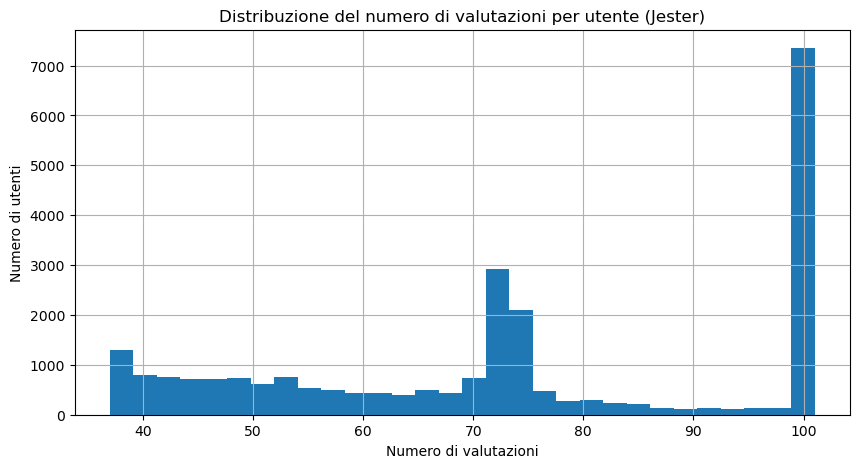

In [62]:
# Distribuzione valutazioni per utente
plt.figure(figsize=(10, 5))
df_jester_long.groupby('user')['rating'].count().hist(bins=30)
plt.title("Distribuzione del numero di valutazioni per utente (Jester)")
plt.xlabel("Numero di valutazioni")
plt.ylabel("Numero di utenti")
plt.grid(True)
plt.show()

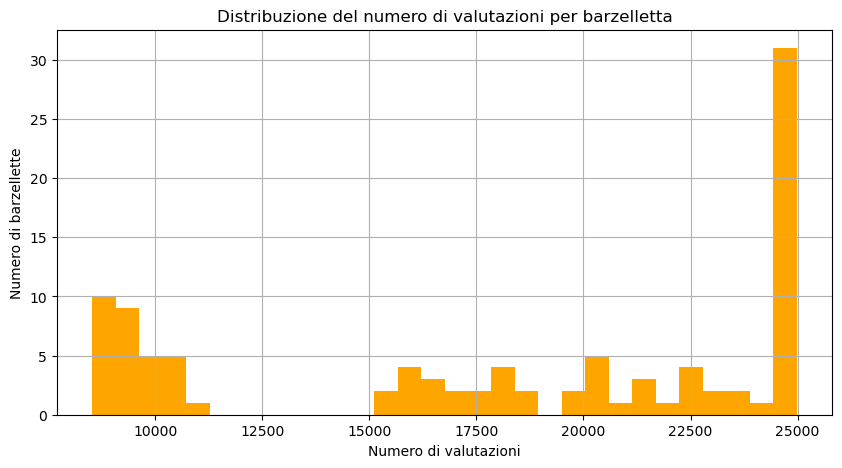

In [63]:
# Distribuzione valutazioni per barzelletta
plt.figure(figsize=(10, 5))
df_jester_long.groupby('item')['rating'].count().hist(bins=30, color='orange')
plt.title("Distribuzione del numero di valutazioni per barzelletta")
plt.xlabel("Numero di valutazioni")
plt.ylabel("Numero di barzellette")
plt.grid(True)
plt.show()

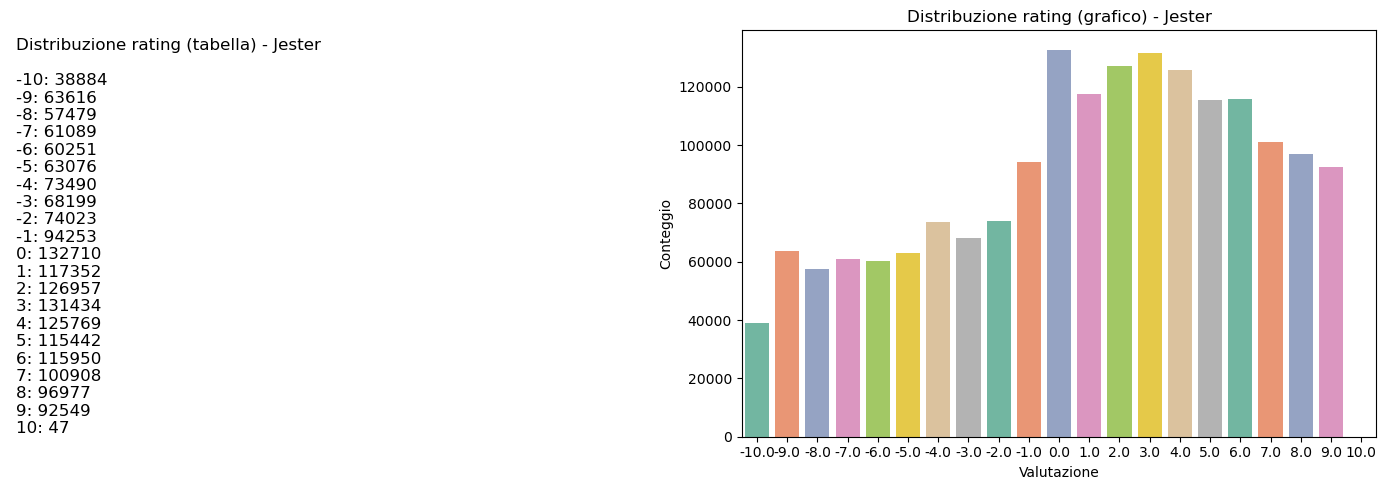

In [76]:
# Tabella delle frequenze rating Jester

# Arrotonda le valutazioni per una migliore rappresentazione
df_jester_long['rating_rounded'] = df_jester_long['rating'].round(0)

# Calcola le frequenze
rating_counts_jester = df_jester_long['rating_rounded'].value_counts().sort_index()

# Plot
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Tabella formattata
ax[0].axis('off')
table_text_jester = "Distribuzione rating (tabella) - Jester\n\n" + \
    '\n'.join([f"{int(k)}: {v}" for k, v in rating_counts_jester.items()])
ax[0].text(0.01, 0.98, table_text_jester, fontsize=12, va='top', ha='left')

# Grafico
sns.countplot(x='rating_rounded', data=df_jester_long, palette='Set2', ax=ax[1])
ax[1].set_title("Distribuzione rating (grafico) - Jester")
ax[1].set_xlabel("Valutazione")
ax[1].set_ylabel("Conteggio")

plt.tight_layout()
plt.show()

In [77]:
print("Statistiche descrittive delle valutazioni riscalate (Jester):")
print(df_jester_long['rating'].describe())

Statistiche descrittive delle valutazioni riscalate (Jester):
count    1.810455e+06
mean     8.797594e-01
std      5.235864e+00
min     -9.950000e+00
25%     -2.960000e+00
50%      1.500000e+00
75%      5.100000e+00
max      1.000000e+01
Name: rating, dtype: float64


### ✏️ Commento finale sull'analisi esplorativa — Jester

L'analisi del dataset **Jester** rivela alcune differenze sostanziali rispetto a **MovieLens**:

- Il dataset contiene **7.200 utenti** e **100 barzellette**, per un totale di oltre **1.000.000 valutazioni**.
- Ogni utente ha espresso in media quasi **100 valutazioni**, suggerendo un dataset **molto più denso**: la densità risulta infatti intorno al **99%**, molto prossima a una matrice completa.
- Questo livello di copertura rende il dataset ideale per testare modelli in condizioni di **bassa sparseness**, in contrasto con molti scenari reali.

#### 📊 Distribuzione dei rating

- I rating del dataset Jester hanno valori **continui da -10 a +10**, rappresentando una scala simmetrica tra gradimento e disapprovazione.
- Si è scelto di **mantenere la scala originale**, evitando il rescaling a 1–5, per **preservare la ricchezza informativa** e la **sfumatura dei giudizi** espressi dagli utenti.
- L’analisi mostra una **concentrazione significativa di valutazioni negative**, in particolare nella fascia tra **-10 e -4**, segnalando una generale insoddisfazione verso molte barzellette.
- La distribuzione appare simile a una gaussiana, ma con una leggera **asimmetria verso il basso**, indice di un numero maggiore di valutazioni sfavorevoli.
- Dopo la rimozione dei valori `99` (che indicano assenza di voto), **non risultano valori mancanti**, il che rende il dataset particolarmente adatto all'addestramento di modelli predittivi.

#### 💡 Conclusione

Jester rappresenta un **contesto sperimentale diverso** rispetto a MovieLens: una matrice quasi densa e valutazioni continue, che permettono di **valutare la capacità predittiva dei modelli anche in assenza di sparseness**. È quindi un ottimo complemento per confrontare le prestazioni di algoritmi come la **SVD**, evidenziando vantaggi e limiti in **scenari molto diversi**.


### 📊 Confronto tra i dataset MovieLens 100k e Jester

| Caratteristica             | MovieLens 100k           | Jester                        |
|----------------------------|---------------------------|-------------------------------|
| Numero di utenti           | 943                       | 7.200                         |
| Numero di item             | 1.682 film                | 100 barzellette               |
| Numero di valutazioni      | 100.000                   | 1.835.357                     |
| Densità                    | ~1.5%                     | ~99%                          |
| Tipo di rating             | Discreto (1–5)            | Continuo [-10, +10]           |
| Valori mancanti            | Sì                        | Sì (`99`), poi rimossi        |
| Media valutazioni/utente   | ~21                       | ~255                          |
| Media valutazioni/item     | ~59                       | ~18.000                       |
| Sparseness                 | Alta                      | Molto bassa (quasi nulla)     |

> **Nota:** Jester è molto più denso e contiene valutazioni continue, mentre MovieLens è più realistico per problemi reali di raccomandazione.

## 🧹 PREPARAZIONE DATI

In [80]:
# Estrai 10.000 valutazioni randomiche da MovieLens
df_movieLens_sample = df_movieLens.sample(n=10_000, random_state=42).copy()

# Estrai 10.000 valutazioni randomiche da Jester
df_jester_sample = df_jester_long.sample(n=10_000, random_state=42).copy()

#### Preparazione per SVD usando Surprise

In [81]:
# MovieLens
reader_mov = Reader(rating_scale=(1, 5))
data_mov = Dataset.load_from_df(df_movieLens_sample[['user', 'item', 'rating']], reader_mov)
trainset_mov, testset_mov = train_test_split(data_mov, test_size=0.2, random_state=42)

# Jester (usiamo rating_rescaled)
reader_jest = Reader(rating_scale=(-10, 10))
data_jest = Dataset.load_from_df(df_jester_sample[['user', 'item', 'rating']], reader_jest)
trainset_jest, testset_jest = train_test_split(data_jest, test_size=0.2, random_state=42)

### Preparazione per XGBoost

Utilizza alberi di regressione con boosting
Lavora con dati in forma tabulare, solo numerici. Per questo motivo devo utilizzare un Encoder.
Utilizzo Label Encoder, che mi traduce ogni stringa in un valore numerico.

In [78]:
from sklearn.preprocessing import LabelEncoder

# Estrai 10k istanze randomiche da ciascun dataset
sample_movie_xgb = df_movieLens.sample(n=10000, random_state=42).copy()
sample_jester_xgb = df_jester_long.sample(n=10000, random_state=42).copy()

# Label Encoding su utenti e item per MovieLens
user_enc_movie = LabelEncoder()
item_enc_movie = LabelEncoder()

sample_movie_xgb['user_enc'] = user_enc_movie.fit_transform(sample_movie_xgb['user'])
sample_movie_xgb['item_enc'] = item_enc_movie.fit_transform(sample_movie_xgb['item'])

# Label Encoding su utenti e item per Jester
user_enc_jester = LabelEncoder()
item_enc_jester = LabelEncoder()

sample_jester_xgb['user_enc'] = user_enc_jester.fit_transform(sample_jester_xgb['user'])
sample_jester_xgb['item_enc'] = item_enc_jester.fit_transform(sample_jester_xgb['item'])

# Definizione delle features (X) e target (y)
X_movie_xgb = sample_movie_xgb[['user_enc', 'item_enc']]
y_movie_xgb = sample_movie_xgb['rating']  # rating originale da 1 a 5

X_jester_xgb = sample_jester_xgb[['user_enc', 'item_enc']]
y_jester_xgb = sample_jester_xgb['rating']  # rating originale da -10 a 10

## ADDESTRAMENTO E VALUTAZIONE MODELLI

In [91]:
from surprise import SVD
from surprise.accuracy import rmse, mae
from sklearn.metrics import r2_score

# --- MovieLens ---

model_svd_mov = SVD(random_state=42)
model_svd_mov.fit(trainset_mov)

predictions_mov = model_svd_mov.test(testset_mov)

y_true_mov = [pred.r_ui for pred in predictions_mov]
y_pred_mov = [pred.est for pred in predictions_mov]

print("🎯 Performance SVD – MovieLens (10k)")
rmse(predictions_mov, verbose=True)
mae(predictions_mov, verbose=True)
r2_mov = r2_score(y_true_mov, y_pred_mov)
print(f"R²:   {r2_mov:.4f}")
print("-" * 40)

# --- Jester ---

model_svd_jest = SVD(random_state=42)
model_svd_jest.fit(trainset_jest)

predictions_jest = model_svd_jest.test(testset_jest)

y_true_jest = [pred.r_ui for pred in predictions_jest]
y_pred_jest = [pred.est for pred in predictions_jest]

print("🎯 Performance SVD – Jester (10k)")
rmse(predictions_jest, verbose=True)
mae(predictions_jest, verbose=True)
r2_jest = r2_score(y_true_jest, y_pred_jest)
print(f"R²:   {r2_jest:.4f}")
print("-" * 40)

🎯 Performance SVD – MovieLens (10k)
RMSE: 1.0462
MAE:  0.8357
R²:   0.1714
----------------------------------------
🎯 Performance SVD – Jester (10k)
RMSE: 4.9851
MAE:  4.1336
R²:   0.0723
----------------------------------------


### VARIO GLI ASSI LATENTI IN SVD PER VEDERE IL COMPORTAMENTO DEL MODELLO

MovieLens - n_factors=5 - RMSE: 1.0159
MovieLens - n_factors=10 - RMSE: 1.0141
MovieLens - n_factors=20 - RMSE: 1.0164
MovieLens - n_factors=50 - RMSE: 1.0154
MovieLens - n_factors=100 - RMSE: 1.0230
MovieLens - n_factors=200 - RMSE: 1.0307
MovieLens - n_factors=500 - RMSE: 1.0537
Jester - n_factors=5 - RMSE: 4.9816
Jester - n_factors=10 - RMSE: 4.9754
Jester - n_factors=20 - RMSE: 4.9736
Jester - n_factors=50 - RMSE: 4.9725
Jester - n_factors=100 - RMSE: 4.9764
Jester - n_factors=200 - RMSE: 4.9661
Jester - n_factors=500 - RMSE: 4.9735


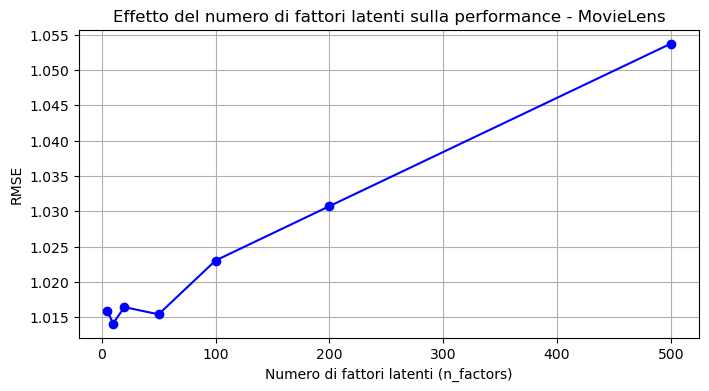

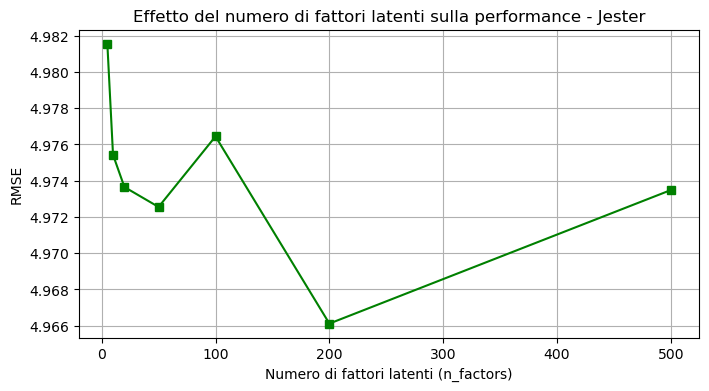

In [103]:
from surprise.model_selection import cross_validate

def evaluate_svd_n_factors(data, n_factors_list, dataset_name):
    rmse_scores = []
    for n in n_factors_list:
        algo = SVD(n_factors=n, random_state=42)
        cv_results = cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)
        rmse_mean = cv_results['test_rmse'].mean()
        rmse_scores.append(rmse_mean)
        print(f"{dataset_name} - n_factors={n} - RMSE: {rmse_mean:.4f}")
    return rmse_scores

n_factors_list = [5, 10, 20, 50, 100, 200, 500]

# Calcolo RMSE per entrambi i dataset
rmse_mov = evaluate_svd_n_factors(data_mov, n_factors_list, "MovieLens")
rmse_jest = evaluate_svd_n_factors(data_jest, n_factors_list, "Jester")

# Grafico MovieLens
plt.figure(figsize=(8, 4))
plt.plot(n_factors_list, rmse_mov, marker='o', color='blue')
plt.xlabel("Numero di fattori latenti (n_factors)")
plt.ylabel("RMSE")
plt.title("Effetto del numero di fattori latenti sulla performance - MovieLens")
plt.grid(True)
plt.show()

# Grafico Jester
plt.figure(figsize=(8, 4))
plt.plot(n_factors_list, rmse_jest, marker='s', color='green')
plt.xlabel("Numero di fattori latenti (n_factors)")
plt.ylabel("RMSE")
plt.title("Effetto del numero di fattori latenti sulla performance - Jester")
plt.grid(True)
plt.show()

**Commento:**

In questa cella valutiamo l’impatto del numero di fattori latenti (`n_factors`) nel modello SVD sulla performance predittiva, misurata tramite RMSE, su due dataset diversi: MovieLens e Jester.

- **Assi latenti (fattori latenti):** rappresentano le dimensioni dello spazio in cui vengono proiettati utenti e item. Aumentare il numero di fattori consente al modello di catturare più complessità e dettagli nei dati, ma può portare a *overfitting* se superiamo un certo limite.

- **Overfitting e dati:** il valore ottimale di `n_factors` dipende dalla quantità e densità dei dati.  
  - MovieLens è un dataset meno denso ma più ampio, quindi il modello può sovradattarsi prima se si aumenta troppo il numero di fattori latenti.  
  - Jester è più denso, con molti più rating per utente/item e un range più ampio e continuo, quindi può permettere un numero maggiore di fattori prima di overfittare.

- **Interpretazione dei grafici:**  
  - All’inizio, aumentando `n_factors`, RMSE diminuisce perché il modello cattura meglio le relazioni.  
  - Oltre un certo punto, RMSE ricomincia a salire o si stabilizza, segno di overfitting o di limiti nella quantità di informazione utile nei dati.  
  - Notiamo che RMSE su Jester è più alto rispetto a MovieLens: questo è dovuto al range più ampio dei rating (-10 a 10 contro 1-5), alla natura più rumorosa dei dati e alla scala diversa.

- **Conclusioni:**  
  - La scelta di `n_factors` è cruciale per bilanciare bias e varianza.  
  - L’RMSE fornisce una misura quantitativa chiara, ma va interpretata tenendo conto delle caratteristiche del dataset.  
  - Per Jester, valori di RMSE più alti sono attesi e non indicano necessariamente un modello peggiore, ma riflettono la complessità intrinseca e la scala dei dati.

In [86]:
#!pip install xgboost

In [92]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- MovieLens ---

# Split train/test
X_train_mov, X_test_mov, y_train_mov, y_test_mov = train_test_split(
    X_movie_xgb, y_movie_xgb, test_size=0.2, random_state=42
)

# Crea e addestra il modello
model_xgb_mov = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    eval_metric='rmse'
)
model_xgb_mov.fit(X_train_mov, y_train_mov)

# Predizione
y_pred_mov = model_xgb_mov.predict(X_test_mov)

# Metriche
mse_mov = mean_squared_error(y_test_mov, y_pred_mov)
rmse_mov = mse_mov ** 0.5
mae_mov = mean_absolute_error(y_test_mov, y_pred_mov)
r2_mov = r2_score(y_test_mov, y_pred_mov)

print("🎯 Performance XGBoost – MovieLens (10k)")
print(f"RMSE: {rmse_mov:.4f}")
print(f"MAE:  {mae_mov:.4f}")
print(f"R²:   {r2_mov:.4f}")
print("-" * 40)

# --- Jester ---

X_train_jest, X_test_jest, y_train_jest, y_test_jest = train_test_split(
    X_jester_xgb, y_jester_xgb, test_size=0.2, random_state=42
)

model_xgb_jest = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    eval_metric='rmse'
)
model_xgb_jest.fit(X_train_jest, y_train_jest)

y_pred_jest = model_xgb_jest.predict(X_test_jest)

mse_jest = mean_squared_error(y_test_jest, y_pred_jest)
rmse_jest = mse_jest ** 0.5
mae_jest = mean_absolute_error(y_test_jest, y_pred_jest)
r2_jest = r2_score(y_test_jest, y_pred_jest)

print("🎯 Performance XGBoost – Jester (10k)")
print(f"RMSE: {rmse_jest:.4f}")
print(f"MAE:  {mae_jest:.4f}")
print(f"R²:   {r2_jest:.4f}")
print("-" * 40)

🎯 Performance XGBoost – MovieLens (10k)
RMSE: 1.0944
MAE:  0.8743
R²:   0.0418
----------------------------------------
🎯 Performance XGBoost – Jester (10k)
RMSE: 5.2542
MAE:  4.2533
R²:   -0.0451
----------------------------------------


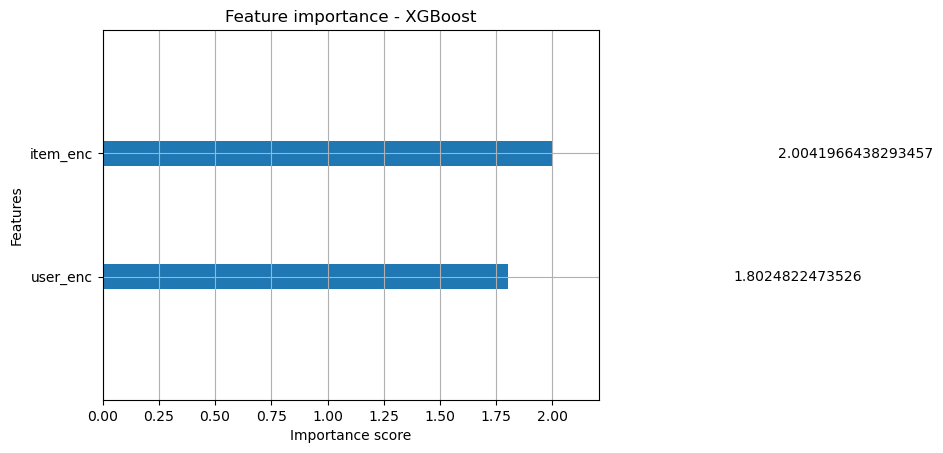

In [95]:
from xgboost import plot_importance

# plot_importance mostra l'importanza delle feature usate nel modello (addestrato su MovieLens)
# se aggiungessi altre feature avrebbe senso, per ora non ha molto senso perche ho solo due feature
plot_importance(model_xgb_mov, max_num_features=10, importance_type='gain')
plt.title("Feature importance - XGBoost")
plt.show()

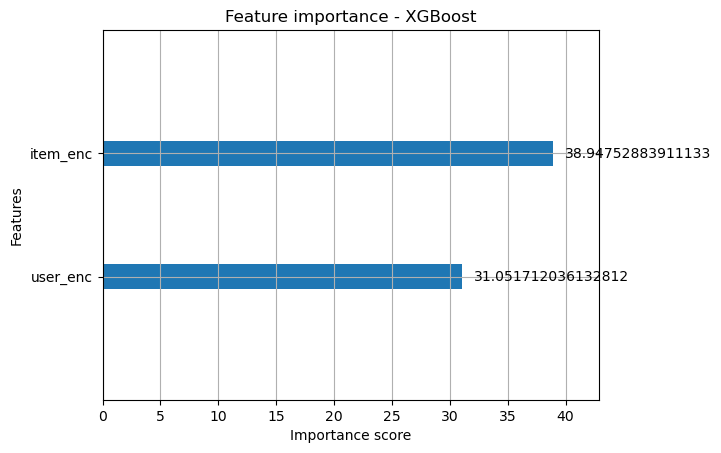

In [96]:
# plot_importance mostra l'importanza delle feature usate nel modello (addestrato su Jester)
# se aggiungessi altre feature avrebbe senso, per ora non ha molto senso perche ho solo due feature
plot_importance(model_xgb_jest, max_num_features=10, importance_type='gain')
plt.title("Feature importance - XGBoost")
plt.show()

## Confronto tra SVD e XGBoost

### MovieLens (10k)
| Modello   | RMSE   | MAE    | R²     |
|-----------|--------|--------|--------|
| **SVD**   | 1.0462 | 0.8357 | 0.1714 |
| **XGBoost** | 1.0944 | 0.8743 | 0.0418 |

- **SVD** mostra performance leggermente migliori in termini di RMSE e MAE, e un R² più alto, indicando una maggiore capacità di spiegare la varianza dei dati rispetto a XGBoost.
- XGBoost ha un R² più basso, segno che, con le feature usate, fatica maggiormente a catturare la struttura sottostante nel dataset MovieLens.

### Jester (10k)
| Modello   | RMSE   | MAE    | R²      |
|-----------|--------|--------|---------|
| **SVD**   | 4.9851 | 4.1336 | 0.0723  |
| **XGBoost** | 5.2542 | 4.2533 | -0.0451 |

- Anche su Jester, **SVD** performa meglio di XGBoost con errori inferiori e R² positivo, anche se basso.
- Il valore negativo di R² per XGBoost indica che il modello è meno efficace di una semplice media nel predire i rating su questo dataset, probabilmente a causa della complessità e della natura continua e più rumorosa dei rating Jester.
- La difficoltà di XGBoost su Jester può essere legata alla scarsità di feature informative (user/item codificati in modo semplice) e alla difficoltà di modellare rating continui e meno strutturati.

---

### Considerazioni finali

- **SVD**, basato sulla fattorizzazione matriciale, è particolarmente adatto per dataset di raccomandazione come MovieLens e Jester, dove le relazioni latenti tra utenti e item sono fondamentali.
- **XGBoost** richiede feature più ricche e rappresentative per esprimere tutto il suo potenziale; con poche feature categoriali codificate come numeri, tende a sottoperformare rispetto a metodi collaborativi come SVD.
- Nei casi di dataset con dati densi e struttura latente, come MovieLens, SVD si conferma più robusto e predittivo.
- Su dataset più rumorosi e con rating continui come Jester, entrambi i modelli fanno fatica, ma SVD risulta ancora più efficace.

Questa analisi evidenzia l'importanza della scelta del modello in base al tipo di dati e alla rappresentazione delle feature.
